<a href="https://colab.research.google.com/github/Andrea039/prueba1/blob/master/Gatos_Correcto_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

**Define Constants**

In [4]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH_DATATRAIN ="../content/drive/My Drive/GatosR/"

**Prepare Traning Data**

In [5]:
filenames = os.listdir(PATH_DATATRAIN)
categories = []
for filename in filenames:
    category = filename.split('(')[0]
    if category == 'Esfinge ':
        categories.append(0)
    elif category == 'Orange Tabby ':
        categories.append(1)
    elif category == 'Siames ':
        categories.append(2)
    elif category == 'Bombay ':
        categories.append(3)
    else:
        categories.append(4)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head(15)

,filename,category
0,Bombay (455).jpg,3
1,Bombay (475).jpg,3
2,Bombay (476).jpg,3
3,Bombay (471).jpg,3
4,Bombay (489).jpg,3
5,Bombay (542).jpg,3
6,Bombay (546).jpg,3
7,Bombay (501).jpg,3
8,Bombay (499).jpg,3
9,Bombay (520).jpg,3


In [ ]:
df.tail()

,filename,category
5833,Siames (350).jpg,2
5834,Siames (340).jpg,2
5835,Siames (345).jpg,2
5836,Siames (361).jpg,2
5837,Siames (317).jpg,2


**See Total In count**

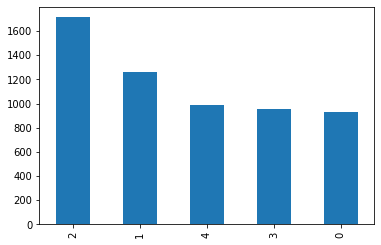

In [7]:
df['category'].value_counts().plot.bar()

**See sample image**

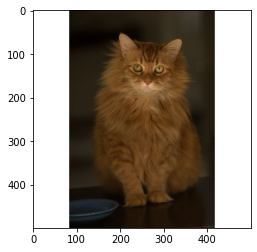

In [8]:
sample = random.choice(filenames)
image = load_img(PATH_DATATRAIN+ sample)
plt.imshow(image)

**Build Model**

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

**Callbacks**


In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

In [11]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accurary', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

**Prepare Data**

In [14]:
df["category"] = df["category"].replace({0: 'Esfinge ', 1: 'Orange Tabby', 2: 'Siames ', 3:'Bombay ', 4:'Smoking ' }) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

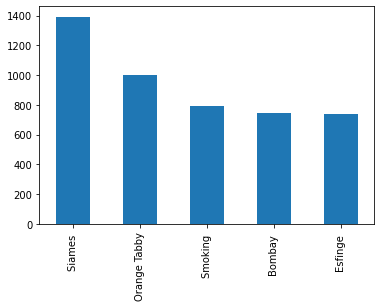

In [16]:
train_df['category'].value_counts().plot.bar()

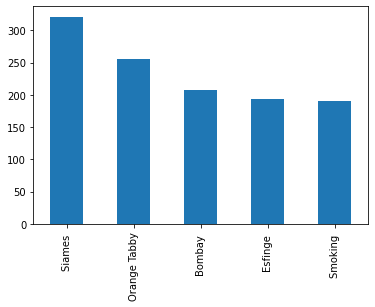

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

**Traning Generator**

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    PATH_DATATRAIN,
    x_col='filename', 
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    #clases = {'catesfinge','catsiames', 'catorange', 'catsmok', 'catangora'}, 
    batch_size=batch_size
)

Found 4670 validated image filenames belonging to 5 classes.


**Validation Generator**

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    PATH_DATATRAIN , 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1168 validated image filenames belonging to 5 classes.


**See how our generator work**

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    PATH_DATATRAIN , 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


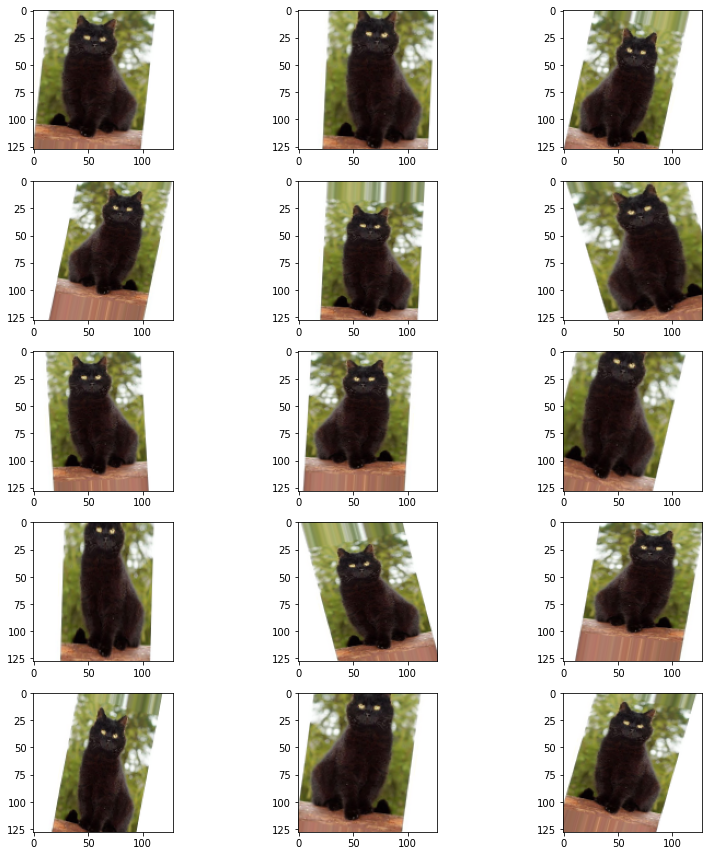

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Fit Model**

In [ ]:
epochs=2 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size, 
    callbacks=callbacks
)

Epoch 1/10
145/145 [==============================] - 248s 2s/step - loss: 0.5266 - accuracy: 0.8066 - val_loss: 0.4904 - val_accuracy: 0.8168
Epoch 2/10
145/145 [==============================] - 252s 2s/step - loss: 0.4990 - accuracy: 0.8174 - val_loss: 0.7361 - val_accuracy: 0.7431
Epoch 3/10
145/145 [==============================] - 256s 2s/step - loss: 0.4843 - accuracy: 0.8217 - val_loss: 0.9619 - val_accuracy: 0.6814
Epoch 4/10
145/145 [==============================] - 254s 2s/step - loss: 0.4806 - accuracy: 0.8254 - val_loss: 0.7777 - val_accuracy: 0.7049
Epoch 5/10
145/145 [==============================] - 253s 2s/step - loss: 0.4426 - accuracy: 0.8353 - val_loss: 0.5413 - val_accuracy: 0.7917
Epoch 6/10
145/145 [==============================] - 249s 2s/step - loss: 0.4382 - accuracy: 0.8413 - val_loss: 1.0682 - val_accuracy: 0.6745
Epoch 7/10
145/145 [==============================] - 255s 2s/step - loss: 0.4185 - accuracy: 0.8435 - val_loss: 0.7403 - val_accuracy: 0.7943

**Save Model**

In [ ]:
model.save_weights("/content/drive/My Drive/SalvarModelo/model.h5")
model.save_weights("/content/drive/My Drive/SalvarModelo/model.weights.h5")
model_json = model.to_json()
with open ("/content/drive/My Drive/SalvarModelo/model.json","w") as json_file:
  json_file.write(model_json)



In [24]:
from keras.models import load_model
#model = load_model ('/content/drive/My Drive/SalvarModelo/model.h5')
model.load_weights('/content/drive/My Drive/SalvarModelo/model.weights.h5')
print('Model loaded!')

Model loaded!


NameError: ignored

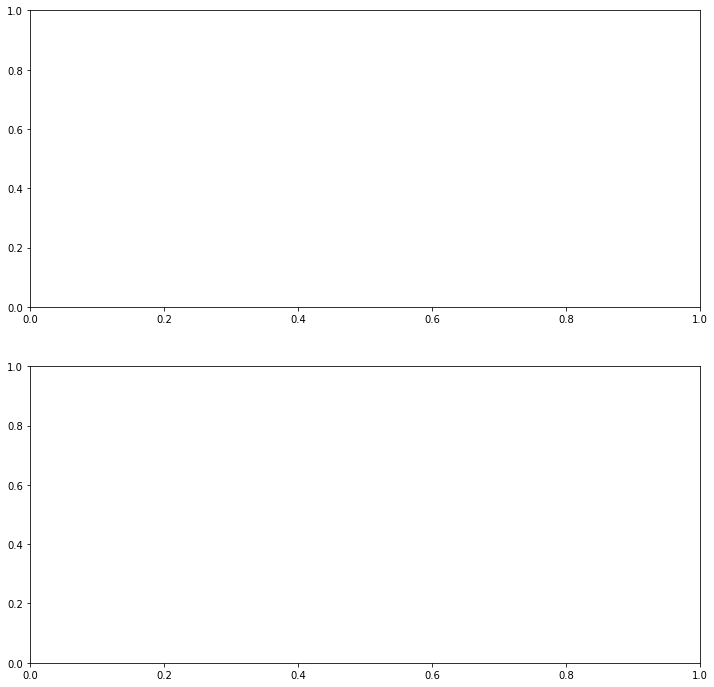

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

**Prepare Testing Data**

In [26]:
test_filenames = os.listdir("../content/drive/My Drive/PruebaGatos")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

**Create Testing Generator**

In [27]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../content/drive/My Drive/PruebaGatos/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 10 validated image filenames.


**Predict**

In [28]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [29]:
test_df['category'] = np.argmax(predict, axis=-1)

In [30]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)


In [31]:
test_df['category'] = test_df['category'].replace({0: 'Esfinge ', 1: 'Orange Tabby ', 2: 'Siames ', 3:'Bombay ', 4:'Smoking ' })

**Virtualize Result**

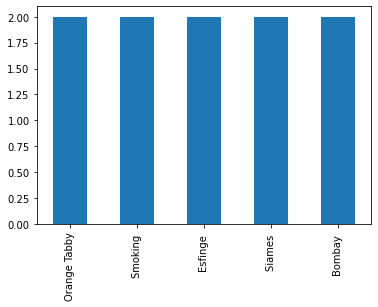

In [32]:
test_df['category'].value_counts().plot.bar()

**See predicted result with images**

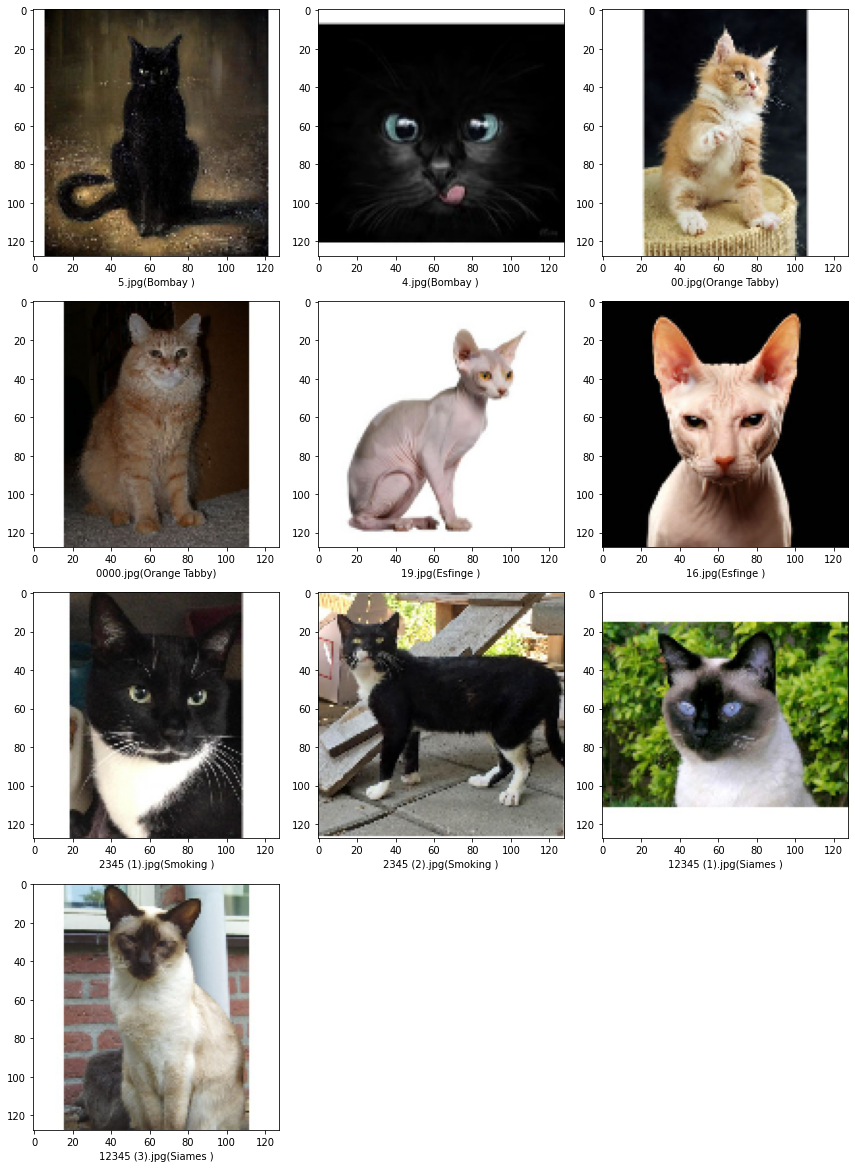

In [33]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../content/drive/My Drive/PruebaGatos/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

**Submission**

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)